In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from numpy.matlib import repmat
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix

## Spectral Clustering on Dataset with Reduced Variables (7 dimensions)

In [2]:
# Reads the reduced csv file
df = pd.read_csv('winequality-red_reduced.csv').iloc[:,1:] #gets rid of the unneeded 1st column with indexes

# Display dataframe
df

,fixed acidity,volatile acidity,citric acid,chlorides,total sulfur dioxide,density,sulphates,quality
0,7.4,0.700,0.00,0.076,34.0,0.99780,0.56,low
1,7.8,0.880,0.00,0.098,67.0,0.99680,0.68,low
2,7.8,0.760,0.04,0.092,54.0,0.99700,0.65,low
3,11.2,0.280,0.56,0.075,60.0,0.99800,0.58,low
4,7.4,0.700,0.00,0.076,34.0,0.99780,0.56,low
...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,0.090,44.0,0.99490,0.58,low
1595,5.9,0.550,0.10,0.062,51.0,0.99512,0.76,low
1596,6.3,0.510,0.13,0.076,40.0,0.99574,0.75,low
1597,5.9,0.645,0.12,0.075,44.0,0.99547,0.71,low


In [3]:
data = df.iloc[:,:-1].to_numpy()
data.shape

(1599, 7)

In [4]:
# The eigsort function taken from HW3
def eigsort(V, eigvals):
    # Sort the eigenvalues from largest to smallest. Store the sorted
    # eigenvalues in the column vector lambd.
    lohival = np.sort(eigvals)
    lohiindex = np.argsort(eigvals)
    lambd = np.flip(lohival)
    index = np.flip(lohiindex)
    Dsort = np.diag(lambd)
    
    # Sort eigenvectors to correspond to the ordered eigenvalues. Store sorted
    # eigenvectors as columns of the matrix vsort.
    M = np.size(lambd)
    Vsort = np.zeros((M, M))
    for i in range(M):
        Vsort[:,i] = V[:,index[i]]
    return Vsort, Dsort

In [5]:
# data needs to be in a numpy array, siqsq is the variance for the algorithm
def spectral_clustering(data, sigsq):
    n = data.shape[0]
    d = data.shape[1]
    Aisq = 0
    for i in range(0,d):
        Aisq = Aisq + np.power(data[:,i], 2)
        
    Dotprod = data.dot(data.T)

    distmat = -repmat(Aisq, n, 1) - repmat(Aisq.reshape(-1,1), 1, n) + 2*Dotprod
    Afast = np.exp(distmat / (2*sigsq))
    A = Afast - np.diag(np.diag(Afast))

    D = np.diag(np.sum(A.T, axis=0))
    L = np.linalg.inv(np.sqrt(D)).dot(A).dot(np.linalg.inv(np.sqrt(D)))

    di, X = np.linalg.eig(L)
    Xsort, Dsort = eigsort(X,di)
    Xuse = Xsort[:,:d]

    Xsq = np.multiply(Xuse, Xuse)
    divmat = repmat(np.sqrt(np.sum(Xsq.T, axis=0)).reshape(-1,1), 1, d)
    Y = np.divide(Xuse, divmat)

    kmeans = KMeans(n_clusters=2).fit(Y)
    kk = kmeans.labels_
    c1 = (kk == 0)
    c2 = (kk == 1)
    
    return A, L, Xuse, Y, c1, c2

In [6]:
# Prints the matrix 'heatmaps' shown in HW3
def matrix_plots(A, L, Xuse, Y):
    
    fig, axes = plt.subplots(2, 2)
    fig.set_figheight(15)
    fig.set_figwidth(15)

    ax = axes[0,0]
    im = ax.imshow(A, extent=[0, 1, 0, 1])
    fig.colorbar(im, ax=ax)
    ax.set_title('Computed A')

    ax = axes[0,1]
    im = ax.imshow(L, extent=[0, 1, 0, 1])
    fig.colorbar(im, ax=ax)
    ax.set_title('Lagrangian L')

    ax = axes[1,0]
    im = ax.imshow(Xuse, extent=[0, 1, 0, 1])
    fig.colorbar(im, ax=ax)
    ax.set_title('Eigensorted X')

    ax = axes[1,1]
    im = ax.imshow(Y, extent=[0, 1, 0, 1])
    fig.colorbar(im, ax=ax)
    ax.set_title('Normalized Y')

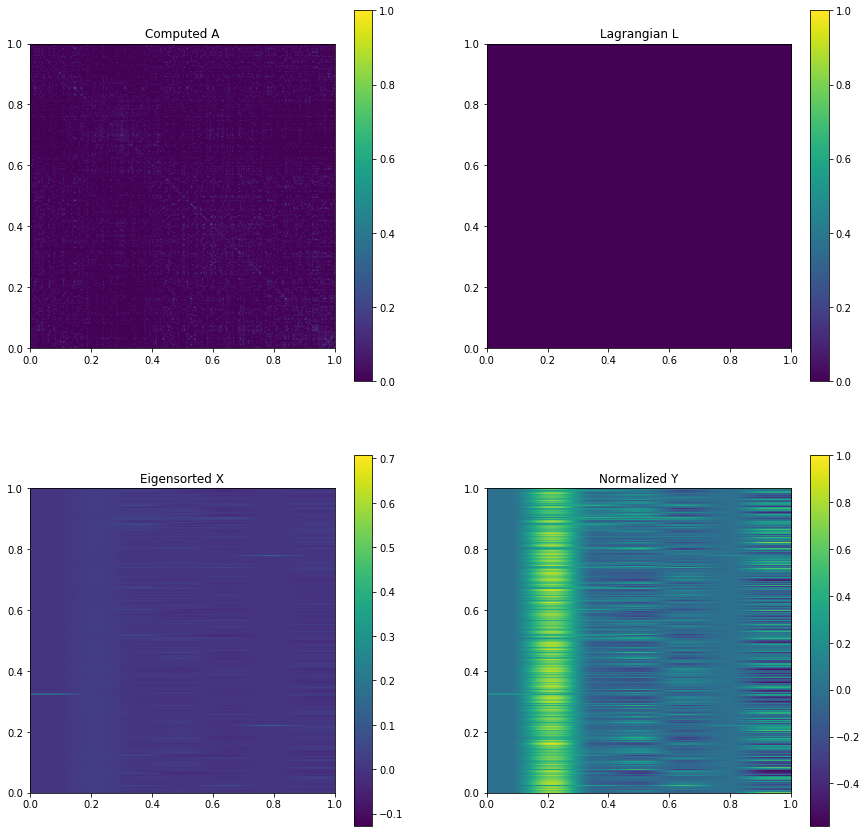

In [7]:
# When trying this with a larger number of dimension (>6), sigsq seems to have to be set to a larger value (>0.5 atleast)
#  or else you'll tend to get a singular matrix error, fewer dimensions should allow you to use a smaller sigsq
A, L, Xuse, Y, c1, c2 = spectral_clustering(data, 1.5) # Going with 1.5 here because it seems to give the best result

matrix_plots(A, L, Xuse, Y)

In [8]:
df['c'] = c1
df['c'] = df['c'].astype(int)
#df = df.iloc[:,[0,1,2,3,11,12]]
df

,fixed acidity,volatile acidity,citric acid,chlorides,total sulfur dioxide,density,sulphates,quality,c
0,7.4,0.700,0.00,0.076,34.0,0.99780,0.56,low,0
1,7.8,0.880,0.00,0.098,67.0,0.99680,0.68,low,1
2,7.8,0.760,0.04,0.092,54.0,0.99700,0.65,low,1
3,11.2,0.280,0.56,0.075,60.0,0.99800,0.58,low,1
4,7.4,0.700,0.00,0.076,34.0,0.99780,0.56,low,0
...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,0.090,44.0,0.99490,0.58,low,1
1595,5.9,0.550,0.10,0.062,51.0,0.99512,0.76,low,1
1596,6.3,0.510,0.13,0.076,40.0,0.99574,0.75,low,1
1597,5.9,0.645,0.12,0.075,44.0,0.99547,0.71,low,1


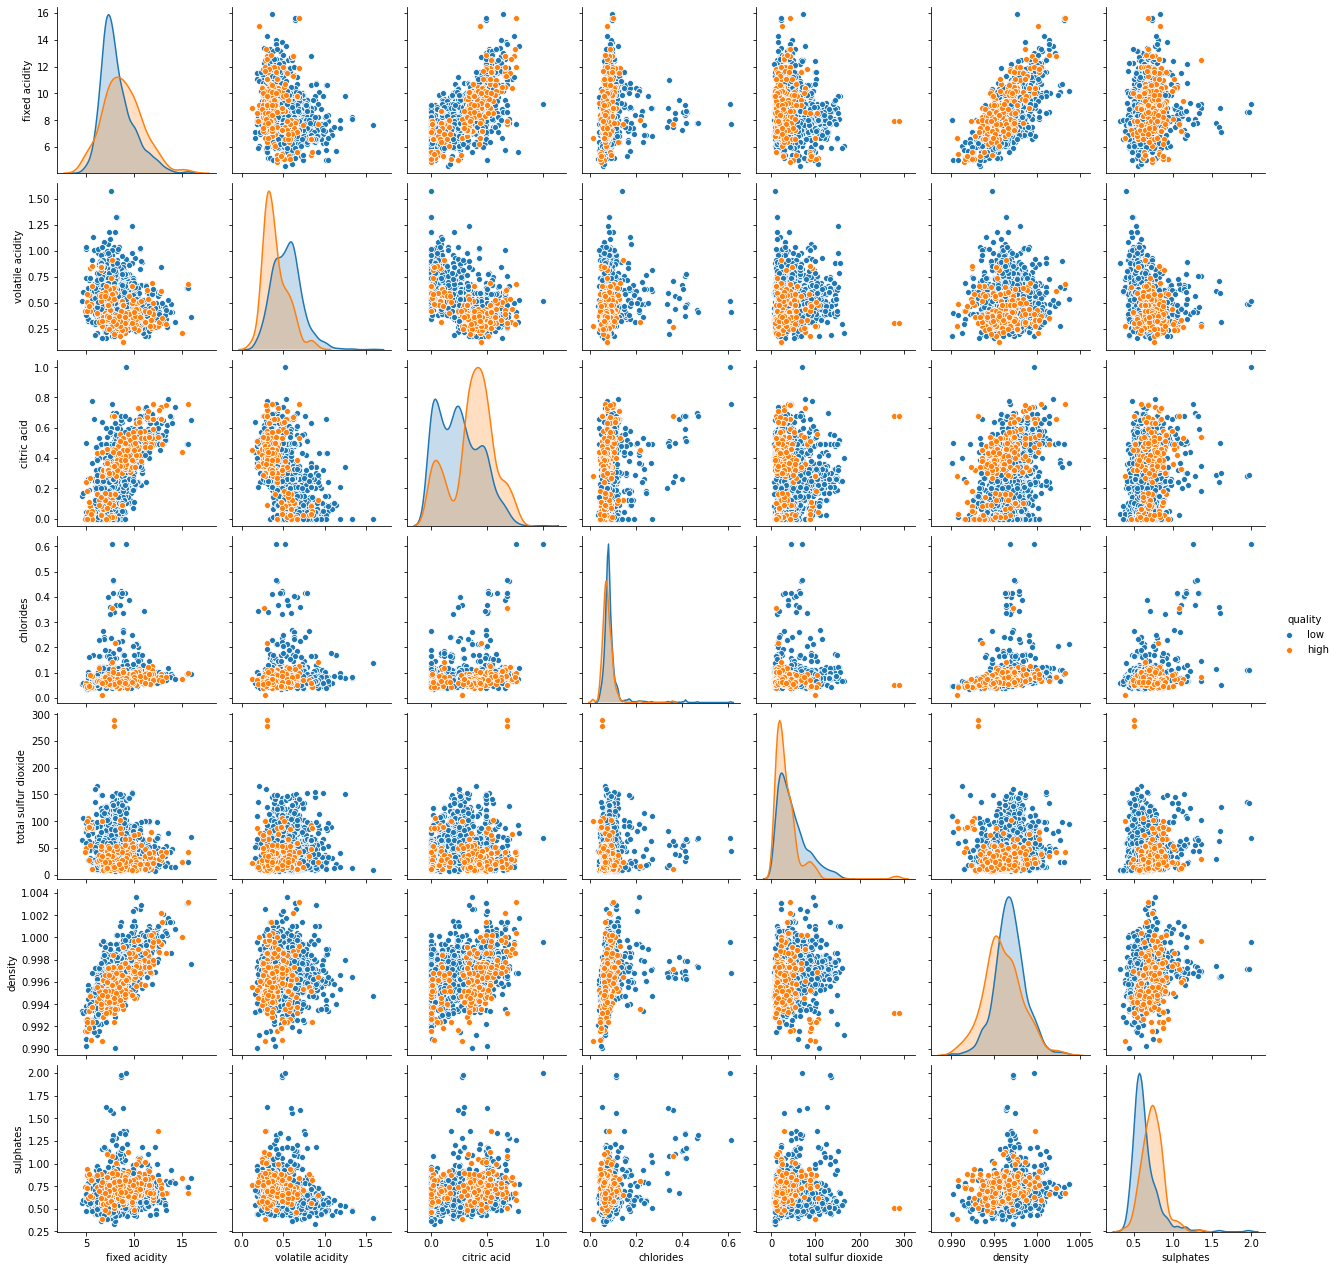

In [9]:
sns.pairplot(df.drop('c',axis=1), hue='quality') #Showing original labels

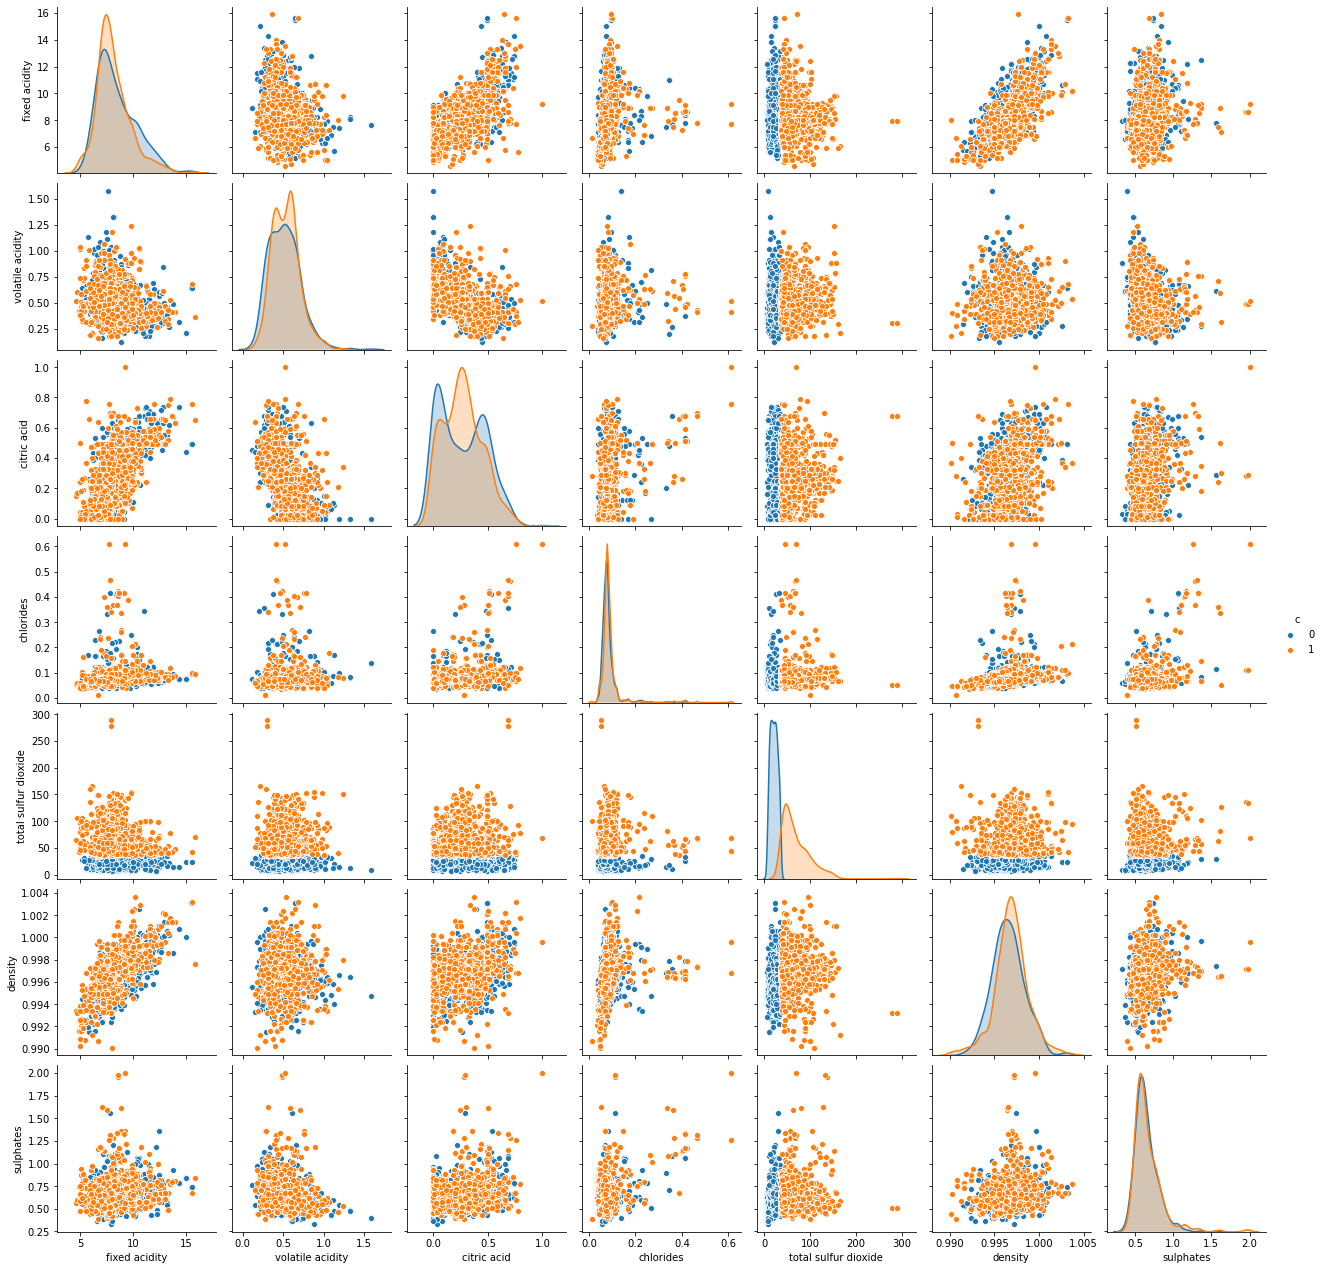

In [10]:
sns.pairplot(df.drop('quality',axis=1), hue='c') #Showing spectral clustering assignments

In [11]:
c_pred = c1.astype(int)
c_true = (df['quality']=='high').astype(int).to_numpy()
conf = confusion_matrix(c_true, c_pred)
pd.DataFrame(conf, index=['truth: low','truth: high'])

,0,1
truth: low,625,757
truth: high,143,74


(Here is just a comparison to the preset labels and should probably have little bearing on the clustering analysis)

This is the confusion matrix comparing the truth labels with the clusters assignments (predicted labels), it should either look like:

$$\begin{bmatrix}
1382 & 0\\ 
0 & 217
\end{bmatrix}\text{ or }\begin{bmatrix}
0 & 1382\\ 
217 & 0
\end{bmatrix}$$

if the algorithm is perfect. 

If the algorithm is good it'll be pretty close.

If the numbers are weighted towards either '0' or '1' then it's not working well, and probably over-grouping the points into one cluster over the other

In [12]:
# Recall
conf[1,1]/(conf[1,0]+conf[1,1])

0.34101382488479265

In [13]:
# Specificity
conf[0,0]/(conf[0,0]+conf[0,1])

0.45224312590448623

If either of these numbers are close to 0, then the overall performance is not good

If both of these numbers are close to 0, then the overall performance is actually great, just the cluster assignments are flipped around

Overall, I'll go with this clustering because with the cluster assignments flipped, the accuracy for each label isn't terribly bad. (1 - 0.34) and (1 - 0.45) are both above 0.50, which is the best we're gonna get through this approach. 

## Spectral Clustering on PCA Dataset (1st 4 PC's)

In [14]:
# Reads the pca transformed csv file
df = pd.read_csv('winequality-red_pca.csv').iloc[:,1:] #gets rid of the unneeded 1st column with indexes

# Display dataframe
df

,0,1,2,3,4,5,6,7,8,9,10,quality
0,-13.224905,-2.023900,-1.126821,-0.399233,-1.085389,-0.198018,0.031547,-0.147051,0.006047,0.008585,0.000262,low
1,22.037724,4.408322,-0.310378,-0.199938,-0.557109,-0.301325,0.223874,0.143165,-0.089312,-0.015483,0.000243,low
2,7.162673,-2.501461,-0.581868,-0.219069,-0.552934,-0.205114,0.136190,0.058480,-0.084793,-0.005749,0.000346,low
3,13.430063,-1.951122,2.634040,-1.574059,-0.063806,0.089092,-0.218923,-0.062244,0.006281,0.004586,-0.000747,low
4,-13.224905,-2.023900,-1.126821,-0.399233,-1.085389,-0.198018,0.031547,-0.147051,0.006047,0.008585,0.000262,low
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,1.129111,16.313102,-1.860069,-0.257109,-0.200974,-0.058238,-0.020342,0.039370,0.019054,0.008953,-0.000058,low
1595,9.489984,21.627525,-1.986558,-0.027199,0.443711,0.040335,0.102762,-0.015382,0.031433,-0.025658,0.000546,low
1596,-3.431354,14.271243,-1.750719,0.174652,0.236271,0.089513,0.078622,0.026835,-0.020558,-0.016826,0.001028,low
1597,1.132878,16.316167,-2.134414,-0.235388,-0.519028,0.015548,0.094561,-0.041732,0.128439,-0.023328,-0.000269,low


In [15]:
data = df.iloc[:,:-1].to_numpy()
data = data[:,[0,1,2,3]] #Select just the first 4 principle components
data.shape

(1599, 4)

<ipython-input-4-bc3b54210403>:16: ComplexWarning: Casting complex values to real discards the imaginary part
  Vsort[:,i] = V[:,index[i]]


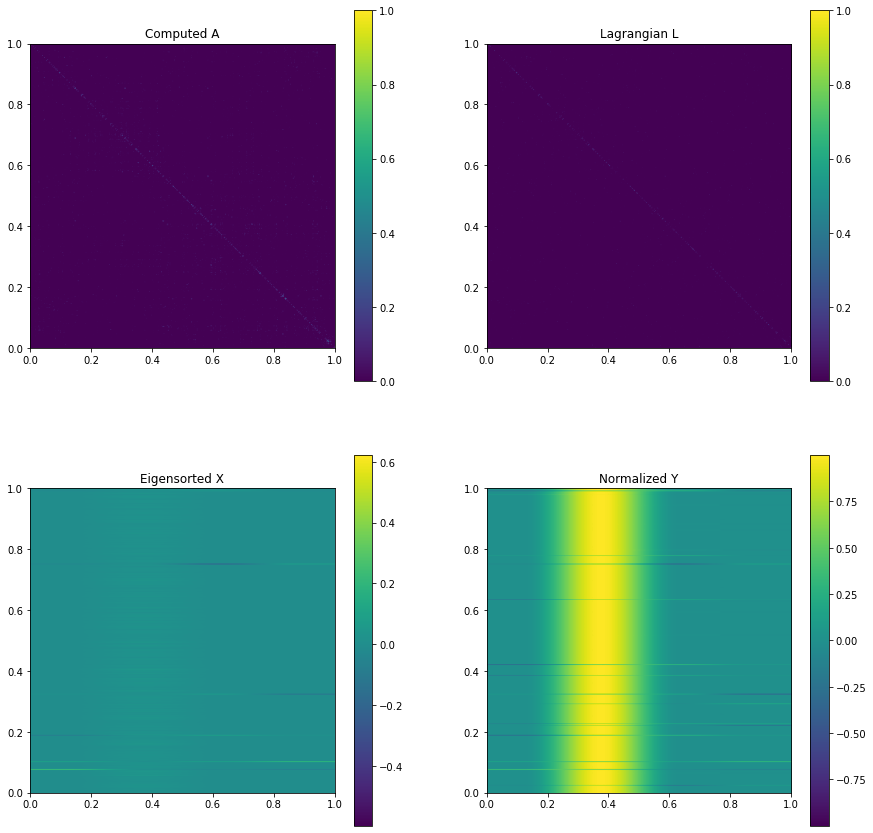

In [16]:
A, L, Xuse, Y, c1, c2 = spectral_clustering(data, 0.7) # 0.7 seemed to work the best

matrix_plots(A, L, Xuse, Y)

In [17]:
df['c'] = c1
df['c'] = df['c'].astype(int)
df = df.iloc[:,[0,1,2,3,11,12]]
df #showing the dataframe with just 1st 4 pc's and quality labels and cluster assignments

,0,1,2,3,quality,c
0,-13.224905,-2.023900,-1.126821,-0.399233,low,1
1,22.037724,4.408322,-0.310378,-0.199938,low,1
2,7.162673,-2.501461,-0.581868,-0.219069,low,1
3,13.430063,-1.951122,2.634040,-1.574059,low,1
4,-13.224905,-2.023900,-1.126821,-0.399233,low,1
...,...,...,...,...,...,...
1594,1.129111,16.313102,-1.860069,-0.257109,low,1
1595,9.489984,21.627525,-1.986558,-0.027199,low,1
1596,-3.431354,14.271243,-1.750719,0.174652,low,1
1597,1.132878,16.316167,-2.134414,-0.235388,low,1


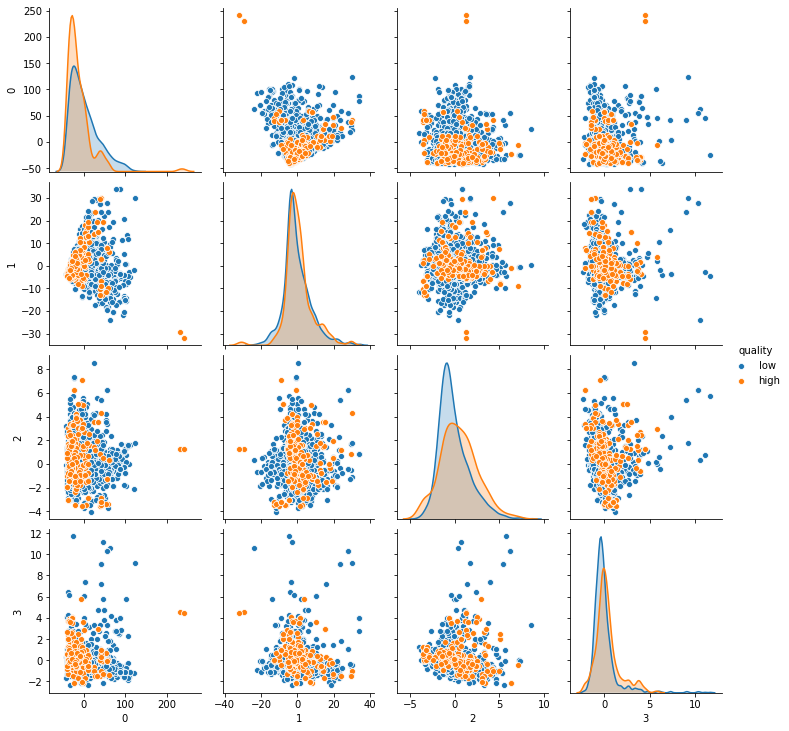

In [18]:
sns.pairplot(df.drop('c',axis=1), hue='quality') #Showing original labels

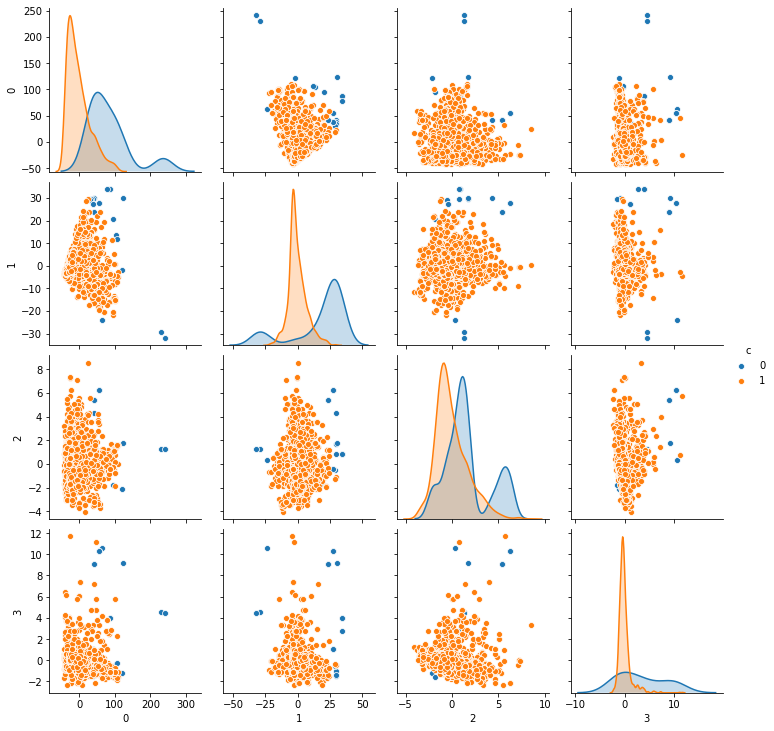

In [19]:
sns.pairplot(df.drop('quality',axis=1), hue='c') #Showing spectral clustering assignments

It seems for the pca data, spectral clustering regardless of sigma squared seems to be heavily influenced by the fact that the data is heavily clustered around a single mass, so only some outlier points get assigned the opposite cluster. 

In [20]:
c_pred = c1.astype(int)
c_true = (df['quality']=='high').astype(int).to_numpy()
conf = confusion_matrix(c_true, c_pred)
pd.DataFrame(conf, index=['truth: low','truth: high'])

,0,1
truth: low,17,1365
truth: high,4,213


In [21]:
# Recall
# Proportion of data labeled high assigned cluster 1
conf[1,1]/(conf[1,0]+conf[1,1])

0.9815668202764977

In [22]:
# Specificity
# Proportion of data labeled low assigned cluster 0
conf[0,0]/(conf[0,0]+conf[0,1])

0.012301013024602027